In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os
import sys
import re
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from IPython.display import display, HTML, clear_output, Image
import pandas as pd
from itertools import product
import math
from deepdiff import DeepDiff

In [23]:
# Styling notebook
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML("<style>" + styles + "</style")

css_styling()

In [24]:
sys.path.insert(1, "/workspaces/ou-af/problem2/")

In [25]:
# import de code
import src.oopnclasses as oopnclasses
import src.oopnbuilder as oopnbuilder
import src.diagrambuilder as diagrambuilder
import src.testobservereplace as testchangeinput
import src.testchangeinput as testobservereplace
import specs.components as componentspecs
import specs.connections as connectionspecs
import specs.assemblies as assemblyspecs
import specs.tests as testspecs

In [26]:
def visualizeStructure(diagram):
#    display(HTML("<style>.container { width:100% !important; }</style>"))

    # print summary of nodes
    print(diagram)

    # view structure
    gnb.showInfluenceDiagram(diagram, size=60)
    
def createUtilityRow(nodelist):
    row_elements = [diagram.utility(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def createCptRow(nodelist):
    row_elements = [diagram.cpt(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def showCPTs(diagram):
    nodes = diagram.nodes()
    for n in nodes:
        if(diagram.isChanceNode(n)):
            gnb.flow.row(diagram.cpt(n))
            
def getDiagramChanceNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isChanceNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printCptTables(diagram, system):
    for component in system.getComponents():
        print("CPT tables for component: " + component.getName())
        createCptRow(getDiagramChanceNodeIdsForComponent(component.getName(), diagram))
        
def getDiagramUtilityNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isUtilityNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printUtilityTables(diagram, system):
    for component in system.getComponents():
        print("Utility tables for component: " + component.getName())
        createUtilityRow(getDiagramUtilityNodeIdsForComponent(component.getName(), diagram))

## Type 2 test:
- voorbeeld systeem met meerdere switches (0, 1, 2), meerdere lampjes (0, 1, 2) en meerdere wires (0, 1, 2, 3, 4, 5)
- voor een deel van de keten zijn er 2 sets aan evidence bijvoorbeeld EnabledStateInputsSwitch:0 / PresentLightOutputsLight2 en EnabledStateInputsSwitch:1 / PresentLightOutputsLight2
    - eis is dat startpunt van de keten een input is en eindpunt een outputnode
    - van een keten in het systeem zijn het beginpunt en het eindpunt bekend, niet de tussenliggende nodes, die moeten dan berekend worden
- indien 2 sets aan evidence worden geconstateerd is dat signaal dat de test is uitgevoerd en dan gaan we terug naar informatiemodel
- mbv informatiemodel berekenen we pad van begin tot einde van de keten via shortest pad methode 
  - wat als er meerdere paden zijn?
- het pad wordt gekopieerd en toegevoegd aan het diagram
  - alleen de nodes die in het pad zitten worden gekopieerd naar een nieuw component
    - output nodes worden dan altijd gekopieerd
  - nodes niet in het pad maar wel in te kopieren component worden hergebruikt uit het originele systeem
    - health nodes worden altijd hergebruikt
  - output van een gekopieerde component wordt verbonden met de health van de oorspronkelijke component
  - een connectienode wordt verbonden met de health van de connectie (todo)

- het extra pad wordt vastgehouden zodat bij inference de extra evidence aan dit pad kan worden verbonden



In [125]:
# gather specs for a system
# system = light + replacedecision + test
components = [componentspecs.light, componentspecs.switch]
connections = [connectionspecs.wire, connectionspecs.wire2]
tests = [testspecs.observeorreplacetest, testspecs.changeinputtest]
assembly = {
    "components"  : components,
    "connections" : connections,
    "structure"   : assemblyspecs.structure3,   # light, switch, wire but multiple times
    "tests"       : tests,
    "testmapping" : testspecs.testmapping11     # 1 test type 2
}

In [126]:
# fill information model with network classes based on descriptions
oopn = oopnbuilder.OopnBuilder(assembly).getOopn()

start building system: structure3
number of components: 6
number of connections: 5
number of tests: 1


In [114]:
# create diagram object
diagram = gum.InfluenceDiagram()
diagram = diagrambuilder.diagramBuilder(diagram, oopn)

adding component: Light
adding component: Switch
adding component: Light1
adding component: Switch1
adding component: Light2
adding component: Switch2
adding connection between: PresentPowerOutputsSwitch and: PresentPowerInputsLight
adding connection between: PresentLightOutputsLight and: PresentPowerInputsSwitch1
adding connection between: PresentPowerOutputsSwitch1 and: PresentPowerInputsLight1
adding connection between: PresentLightOutputsLight1 and: PresentPowerInputsSwitch2
adding connection between: PresentPowerOutputsSwitch2 and: PresentPowerInputsLight2
adding cpt for component: Light
adding cpt for component: Switch
adding cpt for component: Light1
adding cpt for component: Switch1
adding cpt for component: Light2
adding cpt for component: Switch2
adding cpt for connection: Wire
adding cpt for connection: Wire2
adding cpt for connection: Wire3
adding cpt for connection: Wire4
adding cpt for connection: Wire5
adding test: ChangeInputTest
adding node: DecisionChangeInputTestLigh

In [127]:
oopn.copyPathType2Test('PresentPowerInputsSwitch', 'PresentLightOutputsLight2')

# todo verplaatsen naar testchangeinput.py

adding component: Switchcopy
adding component: Lightcopy
adding component: Switch1copy
adding component: Light1copy
adding component: Switch2copy
adding component: Light2copy
adding connection Wirecopy between: Switchcopy and Lightcopy with healthnode: healthWire
adding connection Wire2copy between: Lightcopy and Switch1copy with healthnode: healthWire2
adding connection Wire3copy between: Switch1copy and Light1copy with healthnode: healthWire3
adding connection Wire4copy between: Light1copy and Switch2copy with healthnode: healthWire4
adding connection Wire5copy between: Switch2copy and Light2copy with healthnode: healthWire5


In [128]:
# create diagram object
diagram2 = gum.InfluenceDiagram()

In [129]:
diagram2 = diagrambuilder.diagramBuilder(diagram2, oopn)

adding component: Light
adding component: Switch
adding component: Light1
adding component: Switch1
adding component: Light2
adding component: Switch2
adding component: Switchcopy
node not added, already exists in diagramEnabledStateInputsSwitch
node not added, already exists in diagramhealthSwitch
adding component: Lightcopy
node not added, already exists in diagramhealthLight
adding component: Switch1copy
node not added, already exists in diagramEnabledStateInputsSwitch1
node not added, already exists in diagramhealthSwitch1
adding component: Light1copy
node not added, already exists in diagramhealthLight1
adding component: Switch2copy
node not added, already exists in diagramEnabledStateInputsSwitch2
node not added, already exists in diagramhealthSwitch2
adding component: Light2copy
node not added, already exists in diagramhealthLight2
adding connection between: PresentPowerOutputsSwitch and: PresentPowerInputsLight
adding connection between: PresentLightOutputsLight and: PresentPow

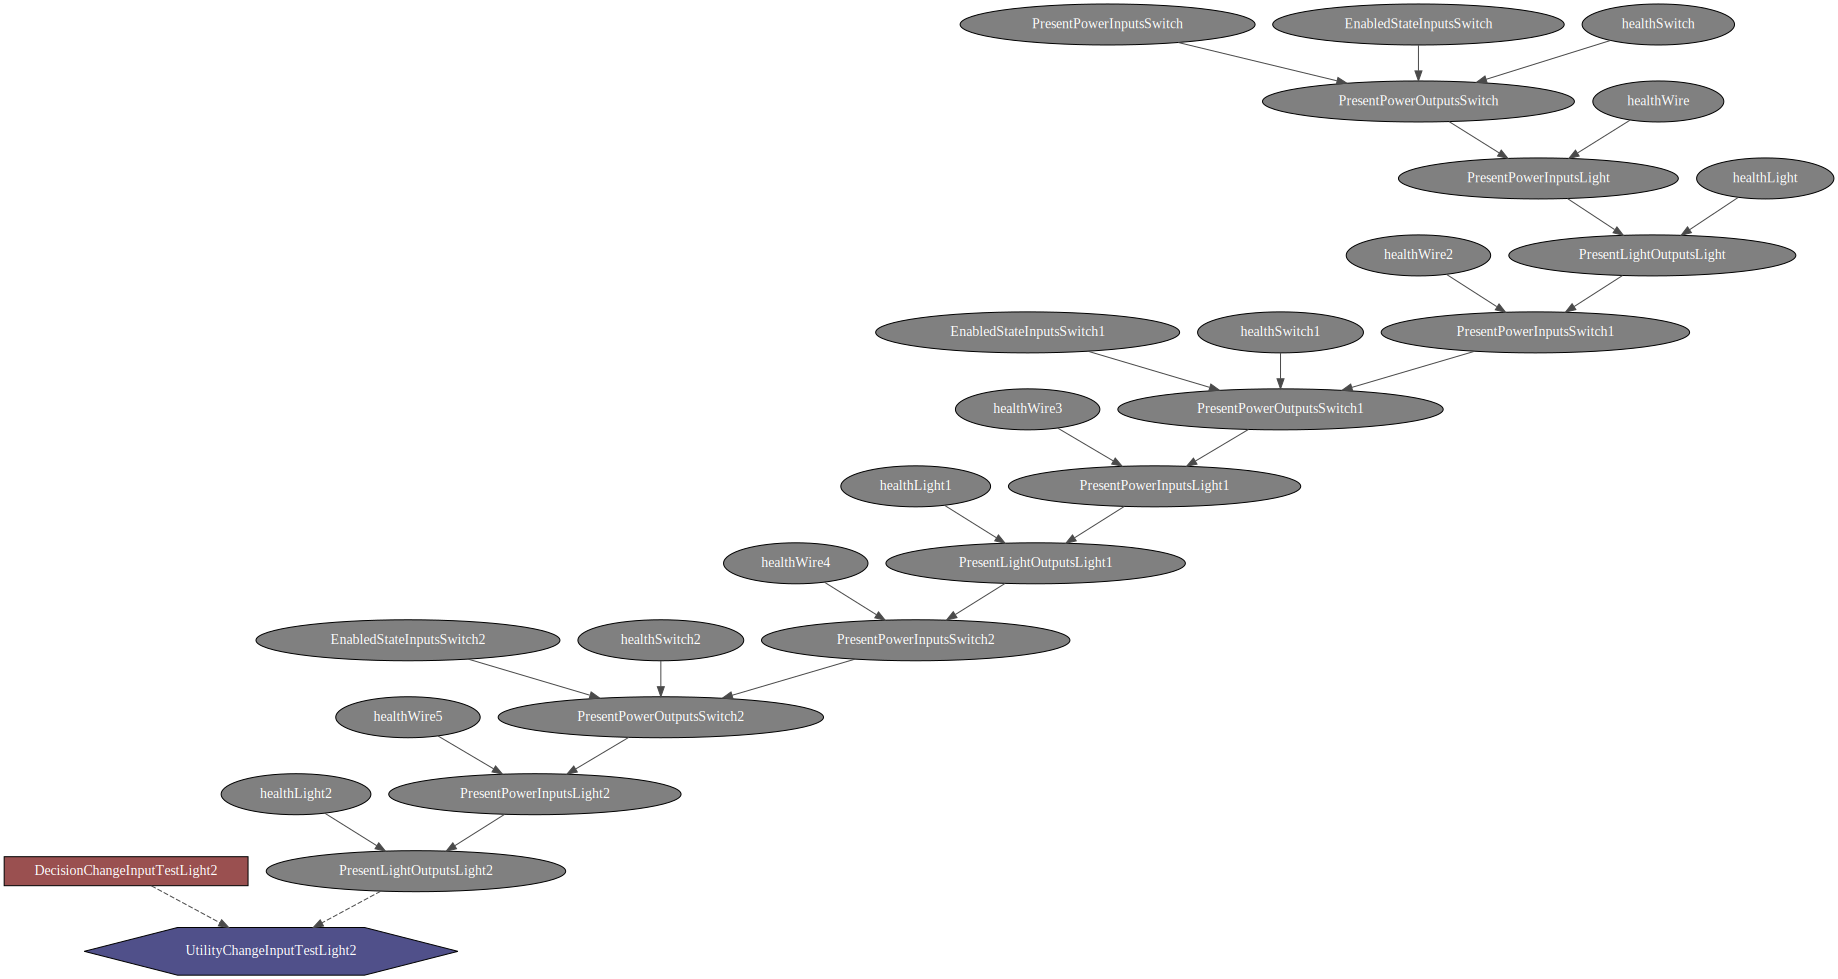

In [117]:
gnb.showInfluenceDiagram(diagram, size=60)

In [146]:
printCptTables(diagram, oopn)

CPT tables for component: Light


CPT tables for component: Switch


CPT tables for component: Light1


CPT tables for component: Switch1


CPT tables for component: Light2


CPT tables for component: Switch2


CPT tables for component: Switchcopy


CPT tables for component: Lightcopy


CPT tables for component: Switch1copy


CPT tables for component: Light1copy


CPT tables for component: Switch2copy


CPT tables for component: Light2copy


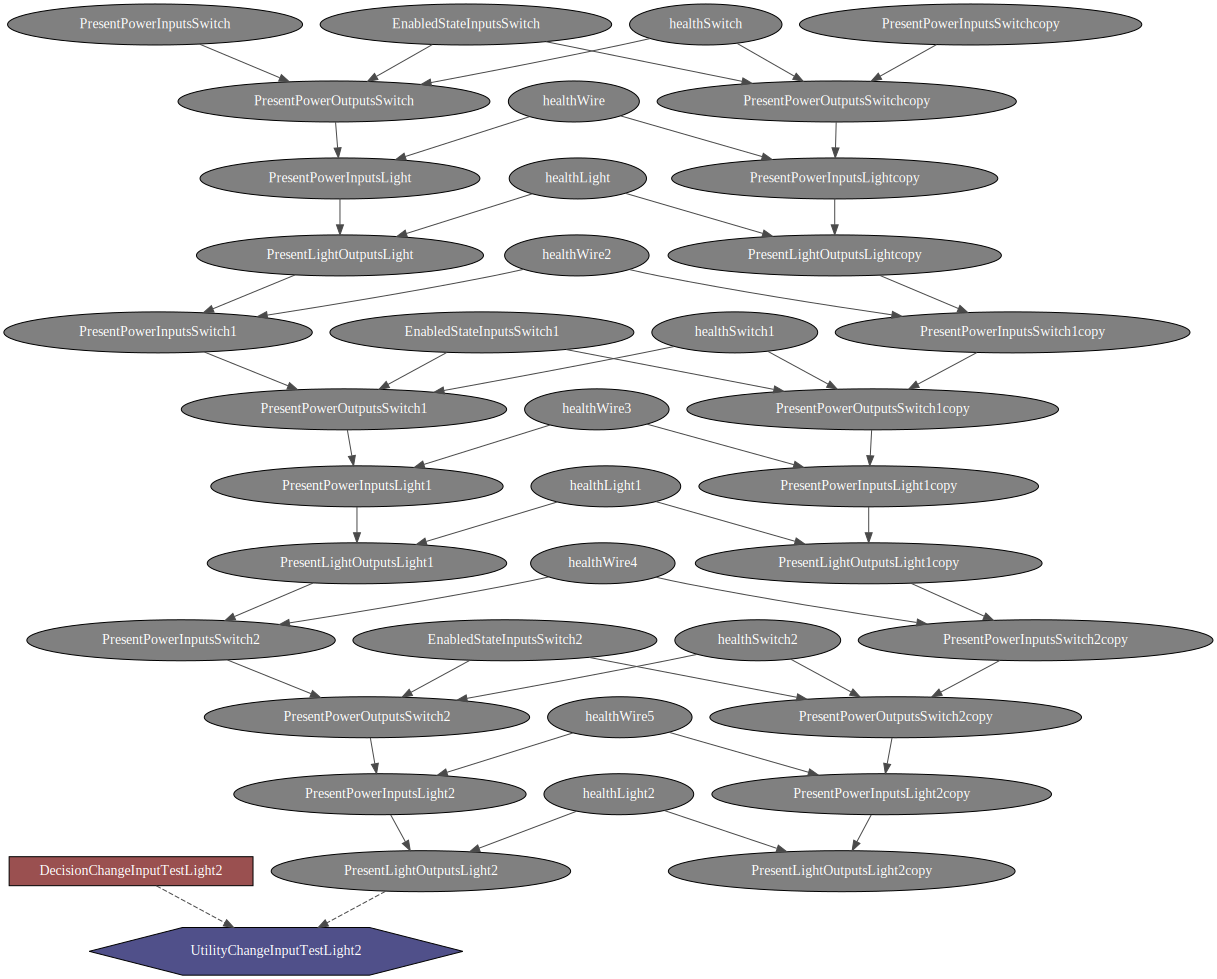

In [130]:
gnb.showInfluenceDiagram(diagram2, size=60)

In [148]:
printCptTables(diagram2, oopn)

CPT tables for component: Light


CPT tables for component: Switch


CPT tables for component: Light1


CPT tables for component: Switch1


CPT tables for component: Light2


CPT tables for component: Switch2


CPT tables for component: Switchcopy


CPT tables for component: Lightcopy


CPT tables for component: Switch1copy


NotFound: [pyAgrum] Object not found: No element with the key <26>

In [131]:
evs = {    
'PresentPowerInputsSwitch':0,
'EnabledStateInputsSwitch':0,

#'PresentLightOutputsLight':0,
#'PresentPowerInputsLight',
#'healthLight',
#'PresentPowerOutputsSwitch',
#'healthSwitch',
#'PresentLightOutputsLight1',
#'PresentPowerInputsLight1':1,
#'healthLight1',
#'PresentPowerOutputsSwitch1',
#'PresentPowerInputsSwitch1',
#'EnabledStateInputsSwitch1',
#'healthSwitch1',
'PresentLightOutputsLight2':1,
#'PresentPowerInputsLight2',
#'healthLight2',
#'PresentPowerOutputsSwitch2',
#'PresentPowerInputsSwitch2',
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'healthLight1',
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'healthLight2',
}
    


In [132]:
ie = gum.ShaferShenoyLIMIDInference(diagram) 
ie.setEvidence(evs)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram,engine=ie, evs=evs, size=200))

In [142]:
evs2 = {    
'PresentPowerInputsSwitch':0,
'EnabledStateInputsSwitch':0,

#'PresentLightOutputsLight':0,
#'PresentPowerInputsLight',
#'healthLight',
#'PresentPowerOutputsSwitch',
#'healthSwitch',
#'PresentLightOutputsLight1',
#'PresentPowerInputsLight1':1,
#'healthLight1',
#'PresentPowerOutputsSwitch1',
#'PresentPowerInputsSwitch1',
#'EnabledStateInputsSwitch1',
#'healthSwitch1',
'PresentLightOutputsLight2':1,
#'PresentPowerInputsLight2',
#'healthLight2',
#'PresentPowerOutputsSwitch2',
#'PresentPowerInputsSwitch2',
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'healthLight1',
#'PresentLightOutputsLight1copy':0,
#'PresentPowerInputsLight1copy':0,
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'PresentPowerOutputsSwitch2copy',
'PresentPowerInputsSwitchcopy':1,
#'healthLight2',
'PresentLightOutputsLight2copy':1,
#'PresentPowerInputsLight2copy':1
}

In [143]:
ie2 = gum.ShaferShenoyLIMIDInference(diagram2) 
ie2.setEvidence(evs2)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram2,engine=ie2, evs=evs2, size=200))

In [ ]:
# visualiseren additionele DAG 
import matplotlib.pyplot as plt
subax1 = plt.subplot()
#nx.draw(G, with_labels=True, font_color='white', node_size=2000)
nx.draw(G, font_color='white', node_size=500)

In [ ]:
# outputtest
testutility = diagram.addUtilityNode(gum.LabelizedVariable("outputTest", "outputTest", 1))
testdecision = diagram.addDecisionNode(gum.LabelizedVariable("testdecision", "testdecisionl", ["yes", "no"]))
testoutcome = diagram.addChanceNode(gum.LabelizedVariable("testoutcome", "testoutcome", ["ok", "problem", "notdone"]))
diagram.addArc(diagram.idFromName("PresentLightOutputsLight"), testutility)
diagram.addArc(testdecision, testutility)
diagram.addArc(testdecision, testoutcome)
diagram.addArc(diagram.idFromName("healthWire"), testoutcome)
diagram.addArc(diagram.idFromName("healthSwitch"), testoutcome)
diagram.addArc(diagram.idFromName("healthLight"), testoutcome)

In [ ]:
printCptTables(diagram, oopn)

In [ ]:
printUtilityTables(diagram, oopn)

In [ ]:
diagram.utility("outputTest")[{"testdecision":"yes", "PresentLightOutputsLight":"no"}] = 4
diagram.utility("outputTest")[{"testdecision":"no", "PresentLightOutputsLight":"no"}] = 3
diagram.utility("outputTest")[{"testdecision":"yes", "PresentLightOutputsLight":"yes"}] = 2
diagram.utility("outputTest")[{"testdecision":"no", "PresentLightOutputsLight":"yes"}] = 1
diagram.utility("outputTest")

In [ ]:
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"ok","testdecision":"yes" }] = [0.98, 0.01, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]


In [ ]:
diagram.cpt(diagram.idFromName("testoutcome"))

In [ ]:
diagram.cpt.posterior("outputTest")

In [ ]:
ie.posteriorUtility("UtilityReplaceWire")

In [ ]:
a = -5*.0087 + -2*.0013
b = 0 + -4* .1238
print(a+b)

In [ ]:
gnb.showInfluenceDiagram(diagram, size=60)

In [ ]:
from collections import defaultdict, deque

# Class to represent a graph using adjacency list


class Graph:
    def __init__(self):
        self.adjList = defaultdict(list)

    # Function to add an edge to the graph
    def addEdge(self, u, v):
        self.adjList[u].append(v)

    # Function to perform Breadth First Search on a graph represented using adjacency list
    def bfs(self, startNode):
        # Create a queue for BFS
        queue = deque()
        visited = [False] * (max(self.adjList.keys()) + 1)

        # Mark the current node as visited and enqueue it
        visited[startNode] = True
        queue.append(startNode)

        # Iterate over the queue
        while queue:
            # Dequeue a vertex from queue and print it
            currentNode = queue.popleft()
            print(currentNode, end=" ")

            # Get all adjacent vertices of the dequeued vertex currentNode
            # If an adjacent has not been visited, then mark it visited and enqueue it
            for neighbor in self.adjList[currentNode]:
                if not visited[neighbor]:
                    visited[neighbor] = True
                    queue.append(neighbor)


# Create a graph
graph = Graph()

# Add edges to the graph
graph.addEdge(0, 1)
graph.addEdge(0, 2)
graph.addEdge(1, 3)
graph.addEdge(1, 4)
graph.addEdge(2, 4)

# Perform BFS traversal starting from vertex 0
print("Breadth First Traversal starting from vertex 0:", end=" ")
graph.bfs(0)


In [ ]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(range(100, 105))
G.add_edges_from([(100, 101), (100, 103), (101,104), (103,102)])


In [ ]:
import matplotlib.pyplot as plt
subax1 = plt.subplot()
nx.draw(G, with_labels=True, font_weight='bold', font_color='white', node_size=1000)


In [ ]:
nx.has_path(G, 100, 104)

In [ ]:
nx.shortest_path(G, 100, 104)

In [ ]:
nx.has_path(G, 100, 104)
nx.shortest_path(G, 100, 104)